# TSMC 買進持有策略

本次範例將以最經典的買進持有策略向您介紹 zipline 回測方法，並且介紹組建 zipline 交易策略最基礎的四大函式 - `initialize`,`handle_data`,`analyze`,`run_algorithm`。

## 導入股價資料

在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為: 
```
!zipline ingest -b tqant 
```
其中 `-b` 為 bundle 之涵義，bundle 為股票價量資訊的載體，`tquant` 則是 bundle 之名稱，可由使用者自定義。在 ingest 之前，需先使用 `os` 設定環境變數，以方便 zipline 接收使用者所欲抓取之資產標的與年份之要求。一般而言，針對環境變數之寫法如下:
```
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw" ==> 導航至 tej api 網域。
os.environ['TEJAPI_KEY'] = "your key" ==> 個人 api key 以驗證身分。
os.environ['mdate'] = "20170601 20230702" ==> 欲抓取資料之日期區間，前者為起始日，後者為終止日。
os.environ['ticker'] = '2330 2337' ==> 所欲抓取股票之代碼。
```

In [1]:
import os 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = "your key"
os.environ['mdate'] = "20170601 20230702"
os.environ['ticker'] = '2330 IR0001'
!zipline ingest -b tquant

Merging daily equity files:


[2023-08-09 05:09:50.565678] INFO: zipline.data.bundles.core: Ingesting tquant.


## Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。分別可以使用:

1. zipline.api.set_slippage

    設定滑價模式，zipline 共提供四種滑價計算方法，詳請請見後續教學-zipline slippage。
   
2. zipline.api.set_commission

    設定手續費模式，zipline 共提供三種手續費計算方法，詳請請見後續教學-zipline commission。

常見的寫法如下:
```
def initialize(context):
    set_slippage(slippage.FixedSlippage())
    set_commission(commission.PerShare(cost=0.00285))
```
除此之外，我們可以注意到 initialize 含有一個參數 __context__，__context__ 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.has_ordered = False) 紀錄是否已經持有台積電股票。
```
def initialize(context):
    context.day = 0
    context.has_ordered = False
    set_slippage(slippage.FixedSlippage())
    set_commission(commission.PerShare(cost=0.00285))
```

In [2]:
from zipline.api import set_slippage, set_commission
from zipline.finance import slippage, commission

def initialize(context):
    context.day = 0
    context.has_ordered = False
    set_slippage(slippage.FixedSlippage())
    set_commission(commission.PerShare(cost=0.00285))

## Handle_data 函式
`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。

其中 `handle_data` 含有兩種參數 -- __context__ , __data__。__context__ 與上述 `initialize` 介紹功能相同，這裡為了記錄交易天數與否持有台積電股票，我們設定為:

```
def handle_data(context, data):
    
    # 每次交易日加 1 天。
    context.day += 1 
    
    # 判別是否持有台積電，請注意我們在 initialize 設定 context.has_ordered 為 False。
    if not context.has_ordered:
```

接著我們引入交易下單函式，下單函式共有六個不同種類，請見教材中以 zipline order 開頭之文件，這裡使用最基礎的下單函式:

### zipline.api.order

買進或賣出 n 股的資產標的。

#### Parameters:
* asset: _zipline.assets.Asset_
        欲下單之資產，請注意資料型態為 zipline 獨有的 Asset 型態。
* amount: _int_
        欲下單股數。
* limit_price: _float_, optional
        限價。
* stop_price: _float_, optional
        停價。

加入下單函式 order(symbol("2330")，其中 symbol("2330") 就是 zipline 中的 Asset 資料型態。之後，我們會將 context.has_ordered 調整成 True，此時下個交易日就不會再度下單，更改完程式如下:
```
def handle_data(context, data):
    
    context.day += 1 
    if not context.has_ordered:
        
        # 下單台積電股票一張 == 1000股
        order(symbol("2330", 1000)
        
        # 設定 context.has_ordered 為 True 以避免下次交易日下單
        context.has_ordered = True
```
最後為了記錄交易天數、是否持有部位與當日價格，我們使用 `record` 函式，其功能為記錄每個交易日的資訊並且在最終 `run_algorithm` 輸出的資料表中，以欄位型式加入所紀錄資訊。其程式編輯方式如下:
```
record( 欄位名稱 = 資訊)
```
這裡我們紀錄當天交易天數 (context.day)、是否持有部位 (context.has_ordered) 與當天收盤價格 (data.current(symbol("2330"), "close"))，其中上面所提到的 data 就是在 `handle_data` 中的 __data__，__data__ 主要功能為保存每天股價的價量資料並且提供呼叫，於本實例我們欲紀錄當天收盤價，於是用到 `data.current()` 函式。

### zipline.data.current

呼叫股票的當日價量資訊。

#### Parameters:
* assets: _zipline.asset.Asset_
        所欲呼叫的股票，請注意資料型態為 zipline 獨有的 Asset 型態。
* fields: _str_
        所欲呼叫的價量資訊，提供 'close', 'open', 'high', 'low' 與 'volume'。

由於我們希望記錄台積電當日收盤價格，因此程式編輯如下:
```
def handle_data(context, data):
    context.day += 1 
    if not context.has_ordered:
        order(symbol("2330", 1000)
        context.has_ordered = True
        
    record( # 紀錄用
        trade_days = context.day,
        has_ordered = context.has_ordered,
        TSMC = data.current(symbol("2330"), "close")
    )
```

In [3]:
from zipline.api import order, record, symbol

def handle_data(context, data):
    context.day += 1
    if not context.has_ordered:
        order(symbol("2330"), 1000)
        context.has_ordered = True
        
    record(
        trade_days = context.day,
        has_ordered = context.has_ordered,
        TSMC = data.current(symbol("2330"), "close")
    )

## Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值表與台積電股價走勢表。其中 `analyze` 有兩個參數 __context__ 與 __perf__，__context__ 就與上述相同，__perf__ 就是最終 `run_algorithm` 輸出的資料表 -- __results__。我們可以提取裡面特定欄位來繪製圖表。

In [4]:
import matplotlib.pyplot as plt
def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1,title='portfolio values')
    ax2 = plt.subplot(212, sharex=ax1)
    perf['TSMC'].plot(ax=ax2,title='TSMC close')
    plt.gcf().set_size_inches(18, 8)
    plt.show()

## Run_algorithm 函式

### zipline.run_algorithm

進行策略回測。

#### Parameters:
* start: _pd.Timestamp_ or _datetime_
        回測起始日期。
* end: _pd.Timestamp_ or _datetime_
        回測結束日期。
* initialize: _callable_
        呼叫 initialize 函式以用於回測。
* capital_base: _int_
        初始資金額度。
* handle_data: _callable_, optional
        呼叫 handle_data 函式以用於回測。
* before_trading_start: _callable_, optional
        呼叫 before_trading_start 函式以用於回測。
* analyze: _callable_, optional
        呼叫 analyze 函式以用於回測。
* data_frequency: _{"daily", "minute"}_, optional
        設置交易頻率。
* bundle: _str_, optional
        設置回測用的 bundle。
* trading_calendar: _TradingCalendar_, optional
        設置交易日曆。
* benchmark_returns: _pd.Series_, optional
        設置指標報酬率。
* treasury_returns: _pd.Series_, optional
        設置無風險利率。

#### Returns:

   Perf: _pd.DataFrame_, 內建欄位有:
   
- benchmark_return：
    當日的benchmark報酬率，若是由`set_benchmark()`設定，則計算方式為(當日benchmark收盤價 / 前一日benchmark收盤價) - 1。
- benchmark_period_return：
    累積的benchmark日報酬率。計算方式：np.nancumprod(1 + `benchmark_return` Series) - 1。
- treasury_return：
    當日的treasury報酬率，直接由TEJ API提供。
- treasury_period_return：
    累積的treasury日報酬率。計算方式：np.nancumprod(1 + `treasury_return` Series) - 1。
- benchmark_volatility：
    benchmark日報酬率的年化波動率，至少需有兩期的報酬率才進行計算。計算方式：(`benchmark_return` Series).expanding(2).std(ddof=1) * np.sqrt(252)
        
- orders：顯示下單紀錄
    每一筆下單用一個字典的方式呈現，其中：
  - id：虛擬單號。
  - dt：下單時間。
  - reason：None, Hold, or Reject（目前不適用）
  - created：建立時間。
  - amount：
    - 下單股數。
    - 若>0表示買進或回補，<0表示賣出或放空。
    - 若有發股票股利或股票分割的情形，除權日當天會更新之前未成交訂單的amount（new_amount = old_amount / ratio，其中ratio = 1/splits）。
  - filled：成交股數。
    - 註：Order execution - 當演算法在某一天下單時，該訂單會在下一個交易日成交，以避免lookahead bias。   
    
  - commission：該筆交易傭金。
  - stop：停損價，若有發股票股利或股票分割的情形，除權日當天會更新之前未成交訂單的stop price（new_stop = old_stop * ratio，其中ratio = 1/splits）。
  - limit：限價價，若有發股票股利或股票分割的情形，除權日當天會更新之前未成交訂單的limit price（new_limit = old_limit * ratio，其中ratio = 1/splits）。
  - stop_reached：
    - 對於buy stop order，若現價>=stop price，則顯示True否則False。
    - 對於sell stop order，若現價<=stop price，則顯示True否則False。
  - limit_reached：
    - 對於buy limit order，若現價<=limit price，則顯示True否則False。
    - 對於sell limit order，若現價>=limit price，則顯示True否則False。
  - sid（asset）：下單的標的。
  - status：若=0表示OPEN（未完全成交），=1表示FILLED（完全成交），=2表示CANCEL（已取消）。
  
  
- transactions：顯示交易紀錄
  - amount：下單股數。
  - dt ： 交易時間。
  - price：成交價（為調整前收盤價，不調整股息、分割、股票股利）。
  - order_id：單號，可與orders中的id比對。
  - sid（asset）：下單的標的。
  - commission：一律為None。傭金資料已經在'orders'底下。
  
- positions：顯示持有部位
  - sid（asset）：下單的標的。
  - amount：該標的總持有股數。除權日當天amount會進行調整（old_amount / ratio = new_amount，其中ratio = 1/splits）。
  - last_sale_price：標的最近一筆的收盤價。
  - cost_basis：每股平均成本（含commissions）。
    - 計算方法為：sum(成交價 * (1+commission) * 股數) / 總股數
    - 除權日當天cost_basis會進行調整（old_cost_basis * ratio = new_cost_basis，其中ratio = 1/splits）。
    - 對於買進或回補來說，commissions會造成cost_basis增加；對於賣出或放空來說，commissions會造成cost_basis減少。
- longs_count：
  - 當日帳上有幾檔長部位股票。可與`positions`比較。
- shorts_count：
  - 當日帳上有幾檔短部位股票。可與`positions`比較。
- long_exposure（long_value）：
  - 當日帳上長部位的市值。
  - 可與`positions`比較。
  - 當投資標的為股票時`long_exposure`和`long_value`兩欄位數值一致。
  - 計算方式為sum(持有股數 * 收盤價) = sum(amount * last_sale_price)，where amount > 0。
- short_exposure（short_value）：
  - 當日帳上短部位的市值。
  - 可與`positions`比較。
  - 當投資標的為股票時`short_exposure`和`short_value`兩欄位數值一致。
  - 計算方式為sum(持有股數 * 收盤價) = sum(amount * last_sale_price)，where amount < 0。
  - short_exposure必然 <= 0。
- ending_exposure（ending_value）：
  - 當日結束時帳上部位的淨市值。
  - 計算方式：`long_exposure` + `short_exposure`
- starting_exposure（starting_value）：
  - 當日開始時帳上部位的淨市值。
  - 為前一日的`ending_exposure`。
- gross_leverage（leverage）：
  - Gross leverage is the sum of long and short leverage exposure per share divided by net asset value（portfolio_value）。
  - 計算方式：（`long_exposure` - `short_exposure`）／`portfolio_value`
- net_leverage：
  - Net leverage is the net leverage exposure per share divided by net asset value（portfolio_value）。
  - 計算方式：（`long_exposure` + `short_exposure`）／`portfolio_value`
- capital_used：
  - 當天的cash flow。>0表示流入，<0表示流出。
  - 計算方式：
    - -1 * sum(`transaction.price` * `transaction.amount`) - sum(`order.commission`) + sum(earn_dividends) + sum(leftover_cash)
  - 註：    
    1. earn_dividends：會於pay_date當天配發。
    2. leftover_cash：分割、股票股利等原因導致股數變動時，若有<1股(fractional_share_count)無法分配的情況時則返回現金。
    3. leftover_cash範例：
       - 若現在持有100股（amount），ratio=3。
       - 新的amount理論上是100/3=33.333，然而不滿一股的部分需轉換成現金 (return cash)。
       - 所以新的amount會是33，剩餘的0.333股（33.333-33）就是fractional_share_count。
       - 由於ratio=3代表該公司股數有發生變動，所以每股平均成本 (cost basis)需調整=原cost basis * 原amount / 新amount 後四捨五入到小數第二位。
       - 所以退回現金(return cash)=(fractional_share_count) * (新cost basis) 再四捨五入到小數第二位

- ending_cash：
  - 當日結束時帳上持有現金。
  - 計算方式：`starting_cash`+`capital_used`
- starting_cash：
  - 當日開始時帳上持有現金。
  - 為前一日的`ending_cash`+sum(earn_dividends)，若無前一日則為`capital_base`。
- pnl：
  - 當日投資組合損益。
  - 計算方式：(`ending_exposure` + `ending_cash`) - (`starting_exposure` + `starting_cash`)。
- returns：
  - 當日報酬率。
  - 計算方式：(當日`portfolio_value`) / (前一日`portfolio_value`) - 1。
  - 存在尾差。
- portfolio_value：
  - 即net asset value，當日投資組合總價值。
  - 計算方式：(`ending_exposure` + `ending_cash`)
- algorithm_period_return：
  - 投資組合累積日報酬率。
  - 計算方式：( 1 + 前一日的`algorithm_period_return`) * ( 1 + 當日`returns`) - 1。
  - 存在尾差。
- algo_volatility：
  - 投資組合日報酬率的年化波動率，至少需有兩期的報酬率才進行計算。
  - 利用empyrical套件計算：
    <br> empyrical.annual_volatility(`returns`Series, period='daily', alpha=2.0, annualization=None)。
  - 具體來說，empyrical套件的計算方式為：`returns`Series.std(ddof=1) * (252 ** (1 / 2))，std為樣本標準差。
  - 用完整`returns`資料，則會回傳最後一日algo_volatility，若扣掉最後一日`returns`，則回傳倒數第二日，以此類推。  
- excess_return：
  - 投資組合累積超額日報酬（相對於`benchmark_period_return`）。
  - 計算方式為：(`algorithm_period_return` - `benchmark_period_return`)。
- max_drawdown：
  - 投資組合累積報酬率從過去的峰值下跌的最大跌幅百分比。
  - 利用empyrical套件計算：empyrical.max_drawdown(`returns` Series)。
  - 具體來說，empyrical套件的計算方式為：
    - cumulative_returns：先計算過去每一日的累積報酬。
    - previous_peaks：計算過去累積報酬率的最大值。
    - daily_drawdown：計算每日回撤 = (cumulative_returns - previous_peaks) / previous_peaks
    - max_drawdown：過去每一日的daily_drawdown取極小值。
- sharpe：
  - 年化夏普比率，衡量每承擔1單位風險，可以獲取多少的報酬。
  - 利用empyrical套件計算：empyrical.sharpe_ratio(`returns` Series, risk_free=0)。
  - 具體來說，empyrical套件的計算方式為：
    <br>np.mean(`returns` Series) / np.std(`returns` Series,ddof=1) * np.sqrt(252)
- sortino：   
  - 年化索提諾比率，衡量承擔單位下方風險，可以獲取多少的報酬。
  - 利用empyrical套件計算：empyrical.sortino_ratio(`returns` Series, required_return=0)。
  - 具體來說，empyrical套件的計算方式為：
    - 計算downside_risk：np.sqrt(np.nanmean(np.square(downside_return))) * np.sqrt(252)，其中downside_return將`returns` Series中>0的數值替換成0。
    - 計算mean_return：np.nanmean(`returns` Series)
    - 計算sortino_ratio =  mean_return / downside_risk * 252。
  - 存在尾差。

- alpha：
  - 年化alpha，衡量投資組合創造超額報酬的能力。
  - 利用empyrical套件計算：empyrical.alpha_beta_aligned(returns=`returns`Series, factor_returns=`benchmark_return` Series,risk_free=0.0)
  - 具體來說，empyrical套件的計算方式為：
    - 計算alpha_series：`returns` Series - (當日`beta` * `benchmark_return` Series)
    - 計算平均alpha：nanmean(alpha_series)
    - 計算年化alpha：(平均alpha + 1) ^ 252 -1  
- beta：    
  - 衡量投資組合相對於整體市場的波動性。
  - 利用empyrical套件計算：empyrical.alpha_beta_aligned(returns=`returns`Series, factor_returns=`benchmark_return` Series,risk_free=0.0)
  - 具體來說，empyrical套件的計算方式為：
    <br>Cov(`benchmark_return` Series, `returns` Series) / Var(`benchmark_return` Series)

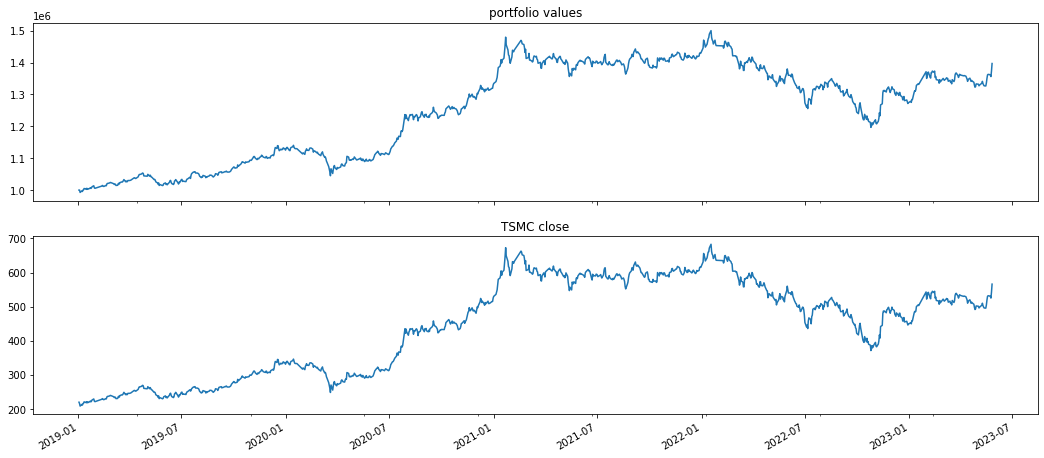

In [5]:
from zipline import run_algorithm
import pandas as pd 

start_date = pd.Timestamp('2018-12-30',tz='utc')
end_date = pd.Timestamp('2023-05-26',tz='utc')

results = run_algorithm(start= start_date,  
                       end=end_date,
                       initialize=initialize,                       
                       capital_base=1e6,                       
                       analyze=analyze,
                       handle_data=handle_data,
                       data_frequency='daily',
                       bundle='tquant'
                       )

In [6]:
results

,period_open,period_close,short_value,long_exposure,benchmark_return,treasury_return,pnl,short_exposure,capital_used,returns,...,treasury_period_return,algorithm_period_return,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,trading_days,period_label
2019-01-02 13:30:00+08:00,2019-01-02 09:01:00+08:00,2019-01-02 13:30:00+08:00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,...,0.0,0.000000,None,None,NaN,NaN,0.000000,0.000000,1,2019-01
2019-01-03 13:30:00+08:00,2019-01-03 09:01:00+08:00,2019-01-03 13:30:00+08:00,0.0,215500.0,0.0,0.0,-2.85,0.0,-215502.85,-0.000003,...,0.0,-0.000003,None,None,-11.224972,-11.224972,-0.000003,0.215501,2,2019-01
2019-01-04 13:30:00+08:00,2019-01-04 09:01:00+08:00,2019-01-04 13:30:00+08:00,0.0,208000.0,0.0,0.0,-7500.00,0.0,0.00,-0.007500,...,0.0,-0.007503,None,None,-9.170376,-9.168633,-0.007503,0.215501,3,2019-01
2019-01-07 13:30:00+08:00,2019-01-07 09:01:00+08:00,2019-01-07 13:30:00+08:00,0.0,213000.0,0.0,0.0,5000.00,0.0,0.00,0.005038,...,0.0,-0.002503,None,None,-1.893153,-2.608781,-0.007503,0.215501,4,2019-01
2019-01-08 13:30:00+08:00,2019-01-08 09:01:00+08:00,2019-01-08 13:30:00+08:00,0.0,211000.0,0.0,0.0,-2000.00,0.0,0.00,-0.002005,...,0.0,-0.004503,None,None,-3.141155,-4.087705,-0.007503,0.215501,5,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 13:30:00+08:00,2023-05-22 09:01:00+08:00,2023-05-22 13:30:00+08:00,0.0,531000.0,0.0,0.0,-1000.00,0.0,0.00,-0.000734,...,0.0,0.362247,None,None,0.816172,1.250657,-0.202433,0.455182,1063,2023-05
2023-05-23 13:30:00+08:00,2023-05-23 09:01:00+08:00,2023-05-23 13:30:00+08:00,0.0,530000.0,0.0,0.0,-1000.00,0.0,0.00,-0.000734,...,0.0,0.361247,None,None,0.813954,1.247253,-0.202433,0.455182,1064,2023-05
2023-05-24 13:30:00+08:00,2023-05-24 09:01:00+08:00,2023-05-24 13:30:00+08:00,0.0,525000.0,0.0,0.0,-5000.00,0.0,0.00,-0.003673,...,0.0,0.356247,None,None,0.804283,1.232180,-0.202433,0.455182,1065,2023-05
2023-05-25 13:30:00+08:00,2023-05-25 09:01:00+08:00,2023-05-25 13:30:00+08:00,0.0,543000.0,0.0,0.0,18000.00,0.0,0.00,0.013272,...,0.0,0.374247,None,None,0.835019,1.282067,-0.202433,0.455182,1066,2023-05


我們可以發現之前使用 `order` 紀錄的 trade_days, has_ordered 與 TSMC 確實以欄位型式記錄在 __results__ 表中。 

In [7]:
results[['trade_days','has_ordered','TSMC']]

,trade_days,has_ordered,TSMC
2019-01-02 13:30:00+08:00,1,True,219.5
2019-01-03 13:30:00+08:00,2,True,215.5
2019-01-04 13:30:00+08:00,3,True,208.0
2019-01-07 13:30:00+08:00,4,True,213.0
2019-01-08 13:30:00+08:00,5,True,211.0
...,...,...,...
2023-05-22 13:30:00+08:00,1063,True,531.0
2023-05-23 13:30:00+08:00,1064,True,530.0
2023-05-24 13:30:00+08:00,1065,True,525.0
2023-05-25 13:30:00+08:00,1066,True,543.0
